## **Data Loading**

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_regression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error



In [7]:

df_p = pd.read_csv("car_price_prediction.csv")

print(df_p.columns.tolist())
columns = df_p.columns.tolist()
df_t = df_p
df_t.head()


['ID', 'Price', 'Levy', 'Manufacturer', 'Model', 'Prod. year', 'Category', 'Leather interior', 'Fuel type', 'Engine volume', 'Mileage', 'Cylinders', 'Gear box type', 'Drive wheels', 'Doors', 'Wheel', 'Color', 'Airbags']


,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


## **Data Checking**

In [8]:
print("Jumlah baris, kolom:", df_t.shape)    
print("\nTipe data:")

df_t.describe()
df_t.info()

Jumlah baris, kolom: (19237, 18)

Tipe data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  int64  
 2   Levy              19237 non-null  object 
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Prod. year        19237 non-null  int64  
 6   Category          19237 non-null  object 
 7   Leather interior  19237 non-null  object 
 8   Fuel type         19237 non-null  object 
 9   Engine volume     19237 non-null  object 
 10  Mileage           19237 non-null  object 
 11  Cylinders         19237 non-null  float64
 12  Gear box type     19237 non-null  object 
 13  Drive wheels      19237 non-null  object 
 14  Doors             19237 non-null  object 
 15  Wheel             19237 non-null  object 


In [9]:
print("Jumlah nilai kosong per kolom:\n", df_t.isnull().sum())
print("Jumlah data duplikat:", df_t.duplicated().sum())
print("Jumlah data Empty String: ", (df_t == '').sum().sum())

Jumlah nilai kosong per kolom:
 ID                  0
Price               0
Levy                0
Manufacturer        0
Model               0
Prod. year          0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Wheel               0
Color               0
Airbags             0
dtype: int64
Jumlah data duplikat: 313
Jumlah data Empty String:  0


In [10]:
df_t['Color'].unique()


array(['Silver', 'Black', 'White', 'Grey', 'Blue', 'Green', 'Red',
       'Sky blue', 'Orange', 'Yellow', 'Brown', 'Golden', 'Beige',
       'Carnelian red', 'Purple', 'Pink'], dtype=object)

**Outlier check**

Identifikasi outlier dilakukan pada seluruh fitur numerik menggunakan visualisasi boxplot, yang menunjukkan adanya nilai ekstrem pada fitur seperti Price. Boxplot dipilih karena mampu menampilkan sebaran data, median, serta nilai ekstrem secara visual.

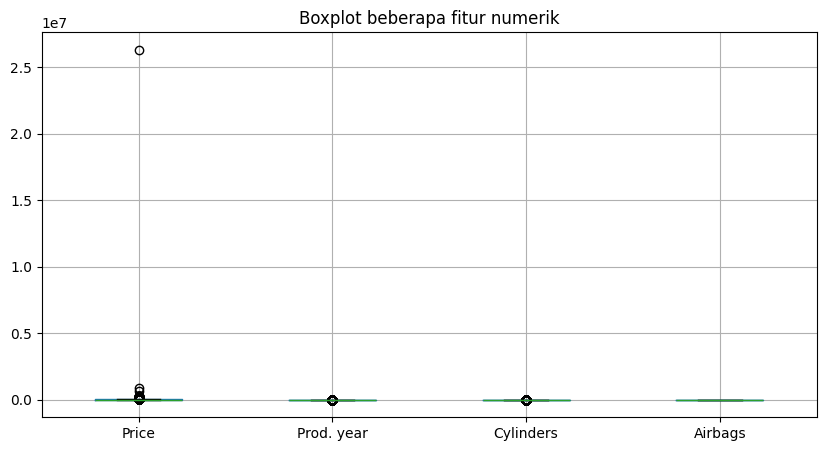

In [13]:
numeric_cols = [
    'Price', 'Levy', 'Prod. year', 'Engine volume',
    'Mileage', 'Cylinders', 'Doors', 'Airbags'
]
numeric_cols = [c for c in numeric_cols
                if c in df_t.columns]

plt.figure(figsize=(10, 5))
df_t[numeric_cols].boxplot()
plt.title("Boxplot beberapa fitur numerik")
plt.show()


## **Data Preparation**
**Penangan Null dan Duplikat**

In [11]:
df_t['Doors'] = df_t['Doors'].fillna(df_t['Doors'].mode()[0])
df_t['Color'] = df_t['Color'].fillna('Unknown')

df_t = df_t.drop_duplicates()


In [12]:
print(df_t.isnull().sum())
print("Duplikat:", df_t.duplicated().sum())

ID                  0
Price               0
Levy                0
Manufacturer        0
Model               0
Prod. year          0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Wheel               0
Color               0
Airbags             0
dtype: int64
Duplikat: 0


**Data Outlier Handling**

Penanganan outlier dilakukan untuk mengurangi pengaruh nilai ekstrem pada fitur numerik yang berpotensi menyebabkan model regresi menjadi bias dan meningkatkan error prediksi, khususnya pada algoritma regresi linear seperti Lasso dan Ridge.

**Metode Penanganan: Interquartile Range (IQR)**

Penanganan outlier dilakukan menggunakan metode Interquartile Range (IQR) dengan langkah sebagai berikut:

Seluruh kolom numerik diidentifikasi secara otomatis menggunakan:

df.select_dtypes(include=np.number)


Untuk setiap fitur numerik dihitung:

Kuartil bawah (Q1, 25%)

Kuartil atas (Q3, 75%)

IQR = Q3 − Q1

Batas outlier ditentukan sebagai:

Lower bound = Q1 − 1.5 × IQR

Upper bound = Q3 + 1.5 × IQR

Baris data yang memiliki setidaknya satu fitur numerik berada di luar rentang tersebut dihapus dari dataset.

Pendekatan ini memastikan bahwa data yang dipertahankan berada dalam rentang distribusi yang wajar untuk setiap fitur numerik.

In [49]:
def handle_outlier_iqr(df, numeric_cols):
    df = df.copy()
    numeric_cols = df.select_dtypes(include=np.number).columns

    Q1 = df[numeric_cols].quantile(0.25)
    Q3 = df[numeric_cols].quantile(0.75)
    IQR = Q3 - Q1

    df = df[~((df[numeric_cols] < (Q1 - 1.5 * IQR)) | 
            (df[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

    numeric_cols = [c for c in numeric_cols if c in df.columns]
    return df

df_t = handle_outlier_iqr(df_t, numeric_cols)

Setelah proses outlier removal, dilakukan kembali visualisasi boxplot untuk memastikan bahwa:

Sebaran data menjadi lebih terpusat

Nilai ekstrem berkurang secara signifikan

Distribusi fitur numerik menjadi lebih stabil untuk pemodelan

Hasil boxplot setelah penanganan menunjukkan distribusi yang lebih seimbang dibandingkan sebelum outlier removal.

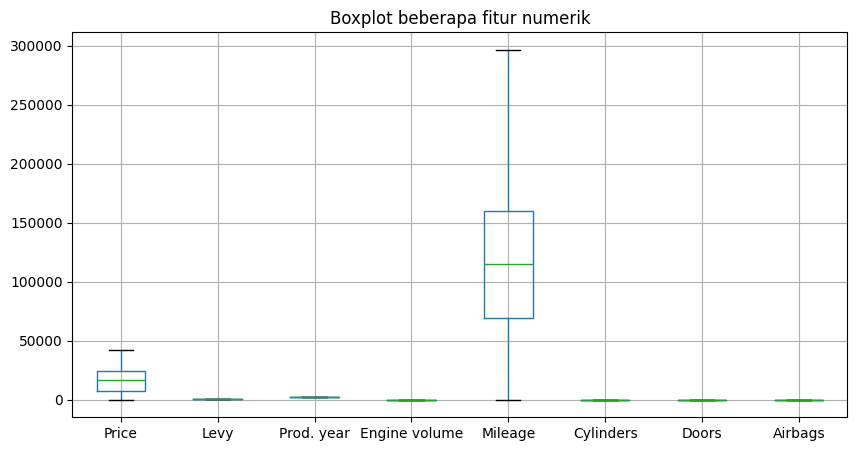

In [50]:
plt.figure(figsize=(10, 5))
df_t[numeric_cols].boxplot()
plt.title("Boxplot beberapa fitur numerik")
plt.show()

## **Encoding**

**Data Encoding** dilakukan dengan mengonversi seluruh fitur kategorik menjadi bentuk numerik agar dapat diproses oleh model regresi. Sebelum encoding, dilakukan pembersihan dan transformasi data seperti konversi string numerik, imputasi nilai hilang menggunakan median atau modus, serta reduksi kardinalitas pada fitur dengan kategori sangat banyak (misalnya Manufacturer dan Model) dengan mempertahankan kategori terbanyak dan mengelompokkan sisanya sebagai Other. Fitur kategorik multi-kelas kemudian dienkode menggunakan LabelEncoder, sedangkan fitur biner dimapping secara langsung ke nilai 0 dan 1. Proses ini menghasilkan dataset yang seluruh fiturnya bersifat numerik dan siap digunakan pada tahap pemodelan serta pipeline regresi.

In [15]:
from sklearn.preprocessing import LabelEncoder

df_t = df_t.drop(columns=['ID'])

df_t['Levy'] = df_t['Levy'].replace('-', np.nan).astype(float)
df_t['Levy'] = df_t['Levy'].fillna(df_t['Levy'].median())

df_t['Mileage'] = df_t['Mileage'].str.replace(' km', '', regex=False).astype(int)

df_t['Engine volume'] = (
    df_t['Engine volume']
    .str.replace(' Turbo', '', regex=False)
    .astype(float)
)

df_t['Doors'] = df_t['Doors'].map({
    '02-Mar': 2,
    '04-May': 4
})

df_t["Doors"] = df_t["Doors"].fillna(df_t["Doors"].mode()[0])

df_t['Leather interior'] = df_t['Leather interior'].map({'Yes': 1, 'No': 0})

top_manufacturer = df_t['Manufacturer'].value_counts().nlargest(10).index
df_t['Manufacturer'] = df_t['Manufacturer'].where(
    df_t['Manufacturer'].isin(top_manufacturer),
    'Other'
)

top_model = df_t['Model'].value_counts().nlargest(20).index
df_t['Model'] = df_t['Model'].where(
    df_t['Model'].isin(top_model),
    'Other'
)

label_cols = [
    'Manufacturer', 'Model', 'Category',
    'Fuel type', 'Gear box type',
    'Drive wheels', 'Wheel'
]

le = LabelEncoder()
for col in label_cols:
    df_t[col] = le.fit_transform(df_t[col])

color_map = {
    'Black': 0,
    'White': 1,
    'Silver': 2,
    'Grey': 3,
    'Red': 4,
    'Blue': 5,
    'Green': 6,
    'Yellow': 7,
    'Sky blue': 8,
    'Orange': 9,
    'Brown': 10,
    'Golden': 11,
    'Beige': 12,
    'Carnelian red': 13,
    'Purple': 14,
    'Pink': 15
}

df_t['Color'] = df_t['Color'].map(color_map)





print(df_t.shape)
print(df_t.dtypes)
df_t.head()

(11139, 17)
Price                 int64
Levy                float64
Manufacturer          int64
Model                 int64
Prod. year            int64
Category              int64
Leather interior      int64
Fuel type             int64
Engine volume       float64
Mileage               int64
Cylinders           float64
Gear box type         int64
Drive wheels          int64
Doors               float64
Wheel                 int64
Color                 int64
Airbags               int64
dtype: object


,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
2,8467,749.0,2,7,2006,3,0,4,1.3,200000,4.0,3,1,4.0,1,0,2
3,3607,862.0,1,14,2011,4,1,2,2.5,168966,4.0,0,0,4.0,0,1,0
4,11726,446.0,2,7,2014,3,1,4,1.3,91901,4.0,0,1,4.0,0,2,4
5,39493,891.0,3,17,2016,4,1,1,2.0,160931,4.0,0,1,4.0,0,1,4
6,1803,761.0,9,15,2010,3,1,2,1.8,258909,4.0,0,1,4.0,0,1,12


In [16]:
print("Jumlah nilai kosong per kolom:\n", df_t.isnull().sum())
print("Jumlah data duplikat:", df_t.duplicated().sum())

Jumlah nilai kosong per kolom:
 Price               0
Levy                0
Manufacturer        0
Model               0
Prod. year          0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Wheel               0
Color               0
Airbags             0
dtype: int64
Jumlah data duplikat: 1810


## **Drop Data Duplicate**

In [17]:
df_t = df_t.drop_duplicates()

print("Duplikat:", df_t.duplicated().sum())
print("Jumlah nilai kosong per kolom:\n", df_t.isnull().sum())
print("Jumlah data duplikat:", df_t.duplicated().sum())
df = df_t

Duplikat: 0
Jumlah nilai kosong per kolom:
 Price               0
Levy                0
Manufacturer        0
Model               0
Prod. year          0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Wheel               0
Color               0
Airbags             0
dtype: int64
Jumlah data duplikat: 0


In [18]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Price'])
y = df['Price']

rs = 86

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=rs
)



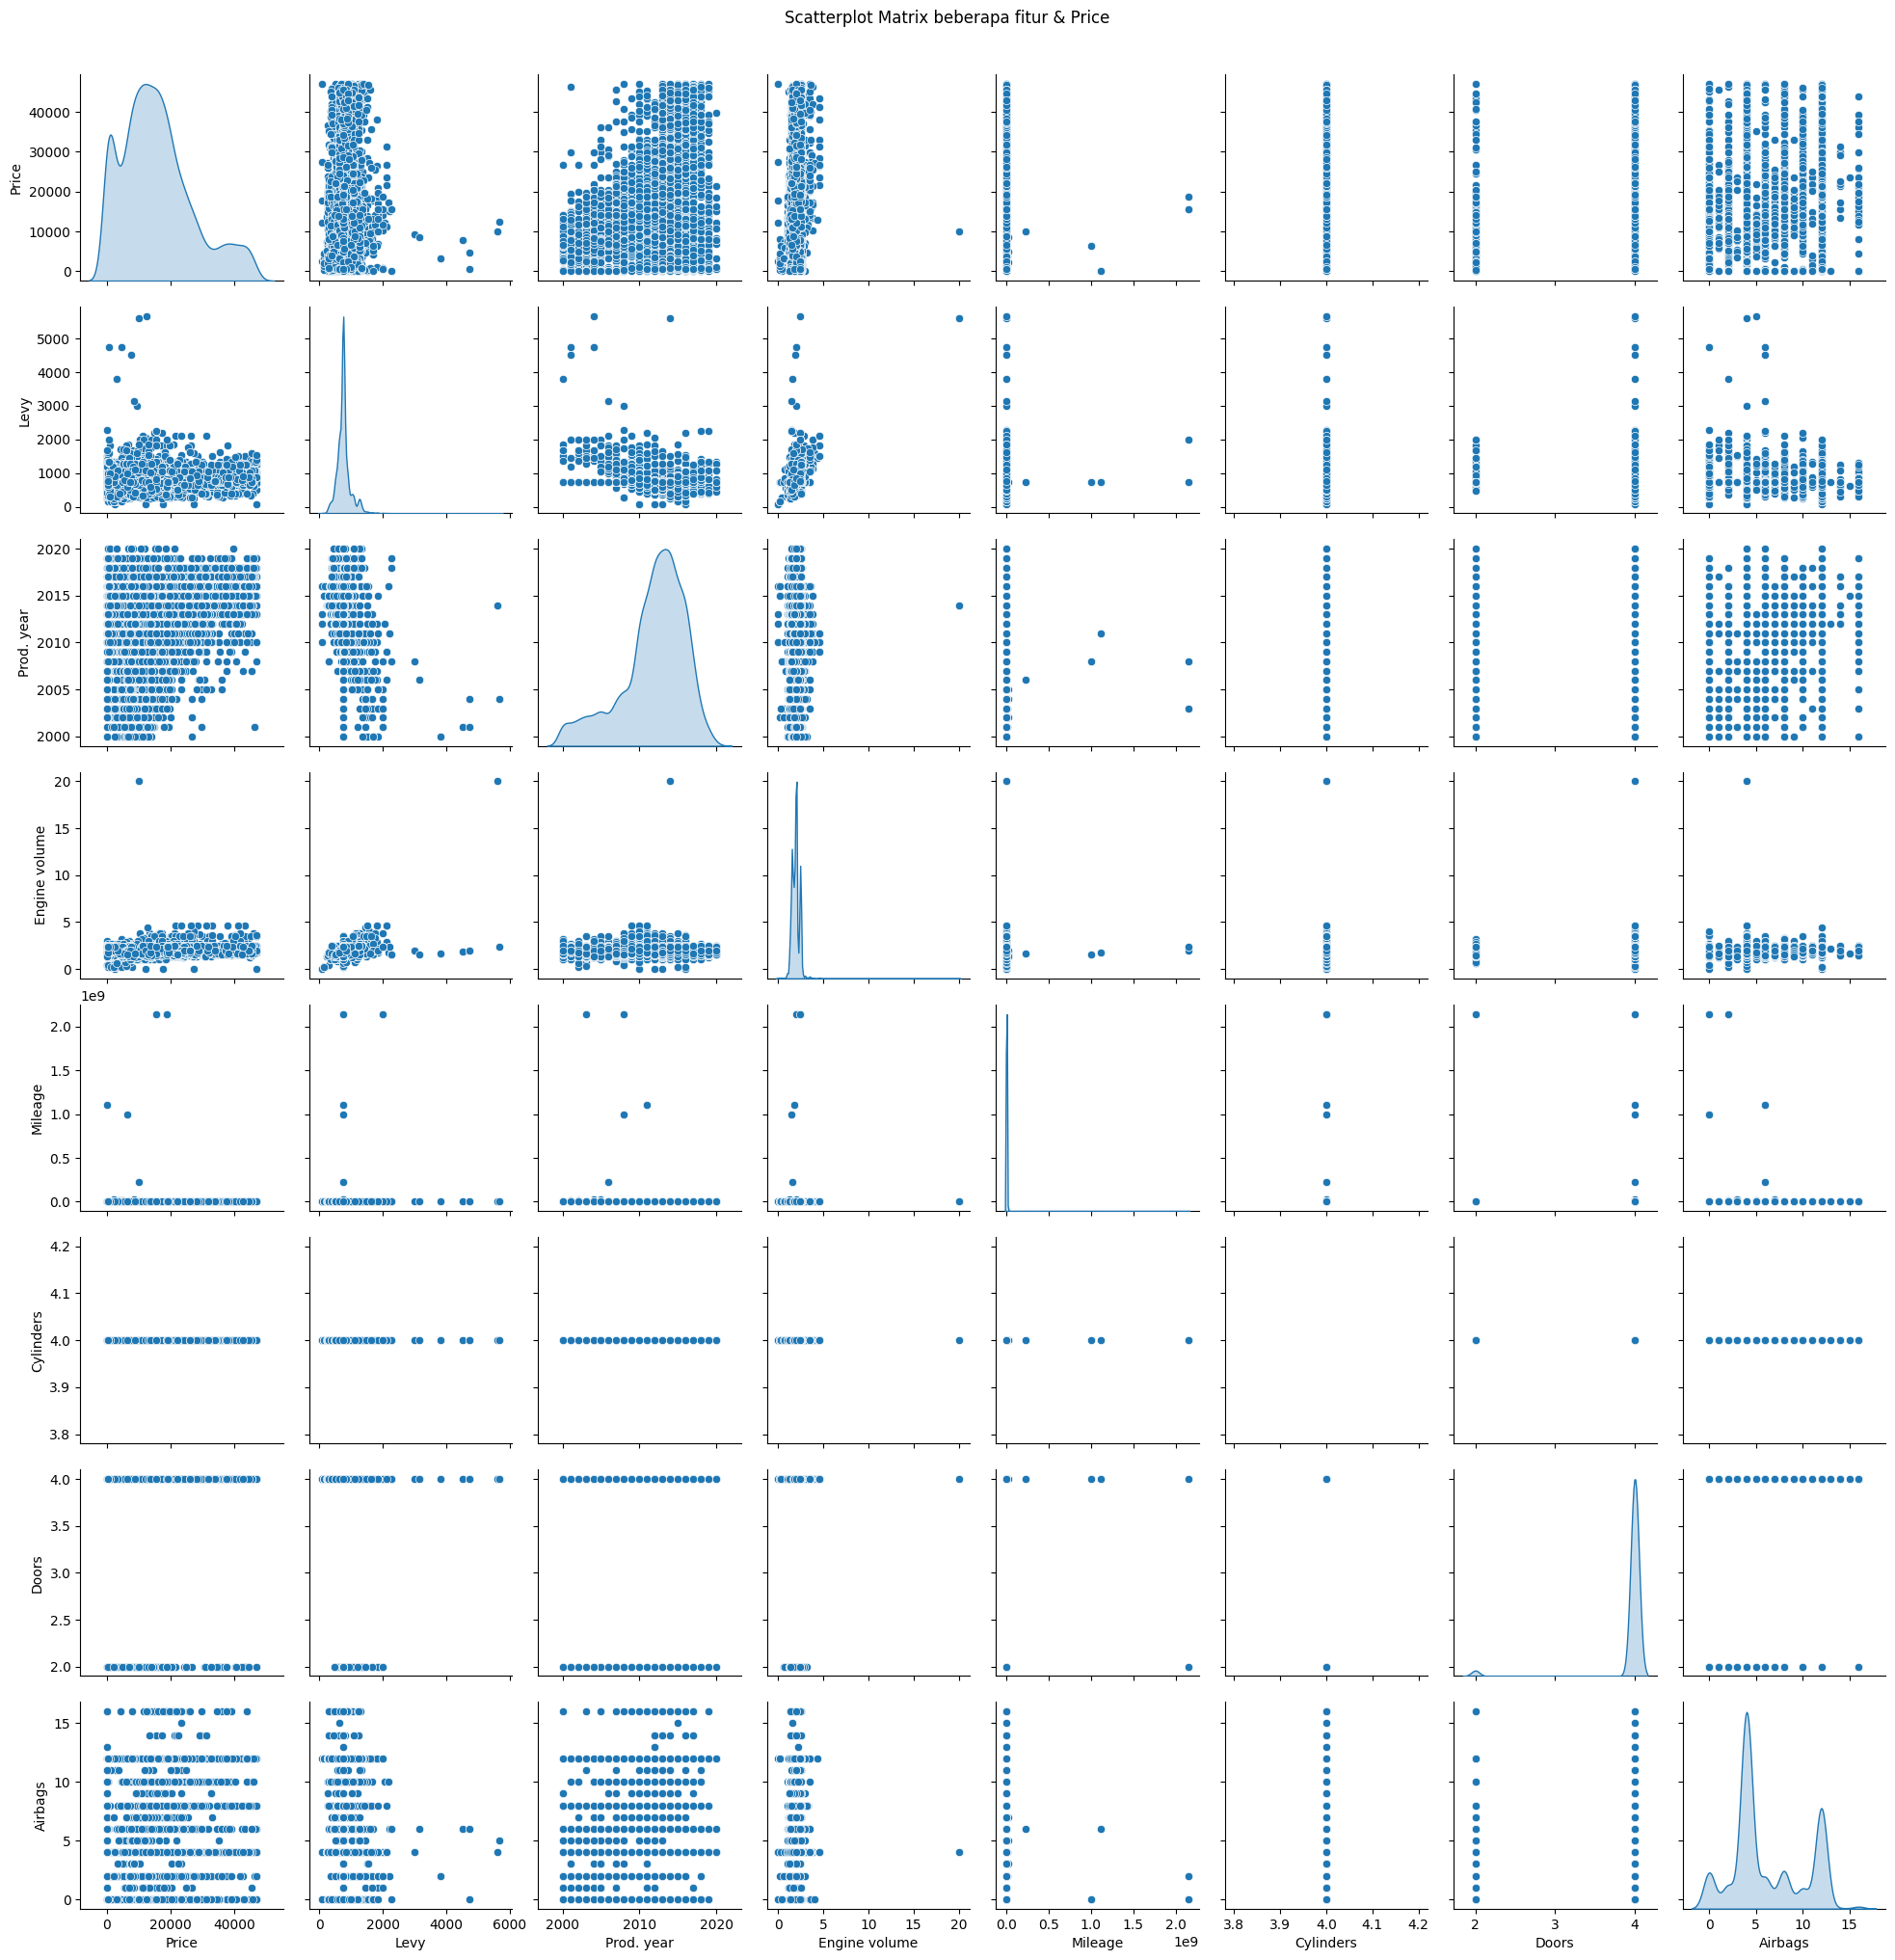

In [19]:
sns.pairplot(df[numeric_cols], diag_kind="kde")
plt.suptitle("Scatterplot Matrix beberapa fitur & Price", y=1.02)
plt.show()

## **Pipeline Lasso**

**Pipeline Lasso** dibangun untuk memastikan seluruh tahapan praproses dan pemodelan dilakukan secara terintegrasi dan konsisten selama proses validasi silang. Pipeline terdiri dari tahap penskalaan fitur menggunakan StandardScaler atau MinMaxScaler, seleksi fitur menggunakan SelectKBest atau SelectPercentile dengan fungsi skor f_regression, serta pemodelan menggunakan algoritma Lasso Regression. Untuk memperoleh kombinasi parameter terbaik, dilakukan GridSearchCV dengan 5-fold cross validation yang mengeksplorasi variasi metode penskalaan, jumlah fitur terpilih, dan nilai regularisasi (alpha). Evaluasi performa model dilakukan menggunakan metrik R², MSE, MAE, dan RMSE, sementara fitur-fitur yang paling relevan diidentifikasi berdasarkan hasil seleksi fitur dari estimator terbaik.

In [20]:

lasso = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(score_func=f_regression)),
    ('model', Lasso(max_iter=10000))
])


param_grid_lasso = [

    {
        'scaler': [StandardScaler(), MinMaxScaler()],
        'feature_selection': [SelectKBest(score_func=f_regression)],
        'feature_selection__k': [5, 10, 15],
        'model__alpha': [0.01, 0.1, 1, 10]
    },

    {
        'scaler': [StandardScaler(), MinMaxScaler()],
        'feature_selection': [SelectPercentile(score_func=f_regression)],
        'feature_selection__percentile': [20, 40, 60],
        'model__alpha': [0.01, 0.1, 1, 10]
    }
]


In [21]:
from sklearn.model_selection import GridSearchCV

grid_lasso = GridSearchCV(
    lasso,
    param_grid_lasso,
    cv=5,
    scoring='r2',
    n_jobs=-1
)


grid_lasso.fit(X_train, y_train)

print("Best score:", grid_lasso.best_score_)
print("Best params:", grid_lasso.best_params_)


Best score: 0.2840245262375081
Best params: {'feature_selection': SelectKBest(score_func=<function f_regression at 0x000002C470C9CA60>), 'feature_selection__k': 15, 'model__alpha': 1, 'scaler': MinMaxScaler()}


In [22]:
best_selector = grid_lasso.best_estimator_.named_steps['feature_selection']
selected_features = X_train.columns[best_selector.get_support()]

print("Selected features:")
print(selected_features)


Selected features:
Index(['Levy', 'Manufacturer', 'Model', 'Prod. year', 'Category',
       'Leather interior', 'Fuel type', 'Engine volume', 'Mileage',
       'Gear box type', 'Drive wheels', 'Doors', 'Wheel', 'Color', 'Airbags'],
      dtype='object')


In [23]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

yl_pred = grid_lasso.best_estimator_.predict(X_test) #y_prednya Lasso

error_matrix = pd.DataFrame({
    'Metric': ['R2', 'MSE', 'MAE', 'RMSE'],
    'Value': [
        r2_score(y_test, yl_pred),
        mean_squared_error(y_test, yl_pred),
        mean_absolute_error(y_test, yl_pred),
        np.sqrt(mean_squared_error(y_test, yl_pred))
    ]
})



## **Pipeline Ridge**
**Pipeline Ridge Regression** dibangun dengan pendekatan yang sama seperti Lasso untuk memastikan proses praproses, seleksi fitur, dan pelatihan model dilakukan secara terintegrasi. Pipeline terdiri dari tahap penskalaan fitur menggunakan StandardScaler atau MinMaxScaler, seleksi fitur menggunakan SelectKBest atau SelectPercentile dengan fungsi skor f_regression, serta pemodelan menggunakan Ridge Regression. Optimasi hiperparameter dilakukan menggunakan GridSearchCV dengan 5-fold cross validation untuk mencari kombinasi terbaik dari metode penskalaan, jumlah fitur terpilih, dan nilai regularisasi (alpha). Kinerja model dievaluasi menggunakan metrik R², MSE, MAE, dan RMSE, sehingga performa Ridge dapat dibandingkan secara langsung dengan Lasso pada kondisi data dan pipeline yang sama.

In [24]:
ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(score_func=f_regression)),
    ('model', Ridge())
])


param_grid_ridge = [
    {
        'scaler': [StandardScaler(), MinMaxScaler()],
        'feature_selection': [SelectKBest(score_func=f_regression)],
        'feature_selection__k': [5, 10, 15],
        'model__alpha': [0.1, 1, 10, 100]
    },
    {
        'scaler': [StandardScaler(), MinMaxScaler()],
        'feature_selection': [SelectPercentile(score_func=f_regression)],
        'feature_selection__percentile': [20, 40, 60],
        'model__alpha': [0.1, 1, 10, 100]
    }
]



In [25]:
grid_ridge = GridSearchCV(
    ridge,
    param_grid_ridge,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

grid_ridge.fit(X_train, y_train)

print("Best Ridge R2:", grid_ridge.best_score_)
print("Best Ridge Params:", grid_ridge.best_params_)

Best Ridge R2: 0.28362375255746
Best Ridge Params: {'feature_selection': SelectKBest(score_func=<function f_regression at 0x000002C470C9CA60>), 'feature_selection__k': 15, 'model__alpha': 100, 'scaler': StandardScaler()}


## **Evaluasi Lasso**

In [26]:
error_matrix

,Metric,Value
0,R2,2.943406e-01
1,MSE,8.658600e+07
2,MAE,7.330100e+03
3,RMSE,9.305160e+03


## **Feature Lasso**

In [27]:
best_selector = grid_lasso.best_estimator_.named_steps['feature_selection']
selected_features = X_train.columns[best_selector.get_support()]

print("Selected features:")
print(selected_features)


Selected features:
Index(['Levy', 'Manufacturer', 'Model', 'Prod. year', 'Category',
       'Leather interior', 'Fuel type', 'Engine volume', 'Mileage',
       'Gear box type', 'Drive wheels', 'Doors', 'Wheel', 'Color', 'Airbags'],
      dtype='object')


## **Data Visualization**

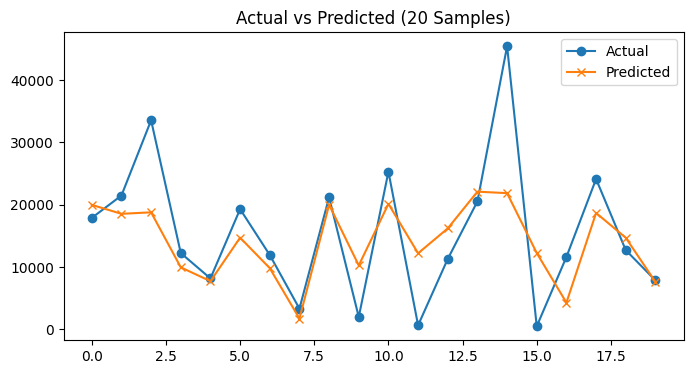

In [28]:
plt.figure(figsize=(8,4))
plt.plot(y_test.values[:20], label='Actual', marker='o')
plt.plot(yl_pred[:20], label='Predicted', marker='x')
plt.legend()
plt.title("Actual vs Predicted (20 Samples)")
plt.show()


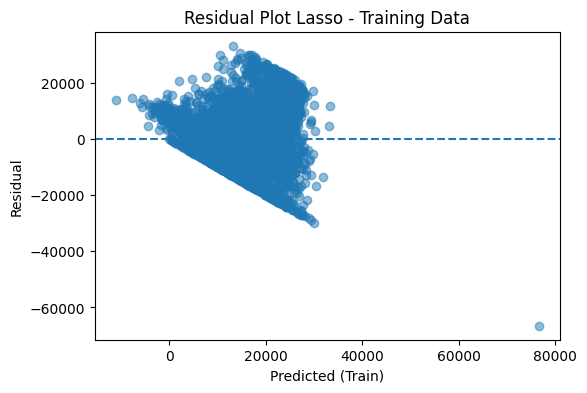

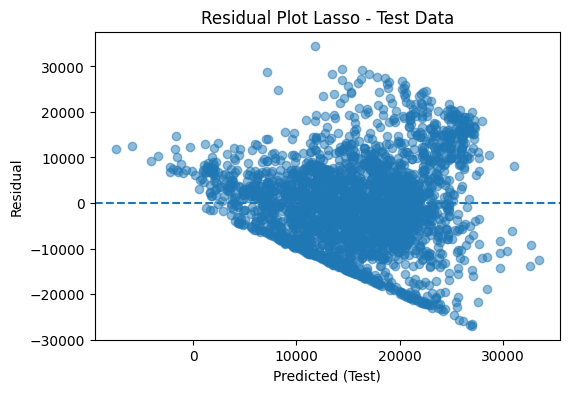

In [29]:
best_model = grid_lasso.best_estimator_


y_pred_train_lasso = best_model.predict(X_train)
y_pred_test_lasso  = best_model.predict(X_test)

residual_train = y_train - y_pred_train_lasso
residual_test  = y_test - y_pred_test_lasso

plt.figure(figsize=(6,4))
plt.scatter(y_pred_train_lasso, residual_train, alpha=0.5)
plt.axhline(0, linestyle='--')
plt.xlabel("Predicted (Train)")
plt.ylabel("Residual")
plt.title("Residual Plot Lasso - Training Data")
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(y_pred_test_lasso, residual_test, alpha=0.5)
plt.axhline(0, linestyle='--')
plt.xlabel("Predicted (Test)")
plt.ylabel("Residual")
plt.title("Residual Plot Lasso - Test Data")
plt.show()

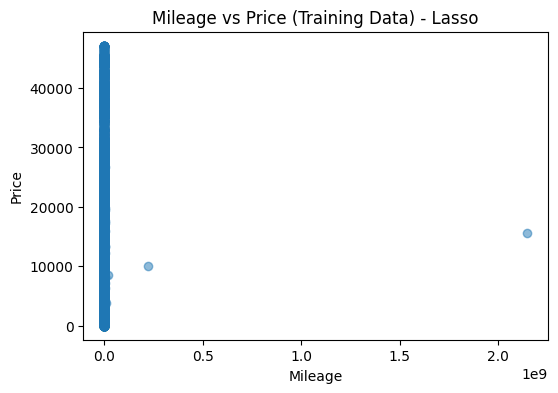

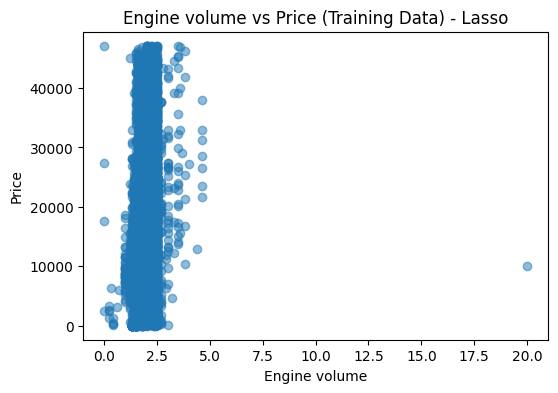

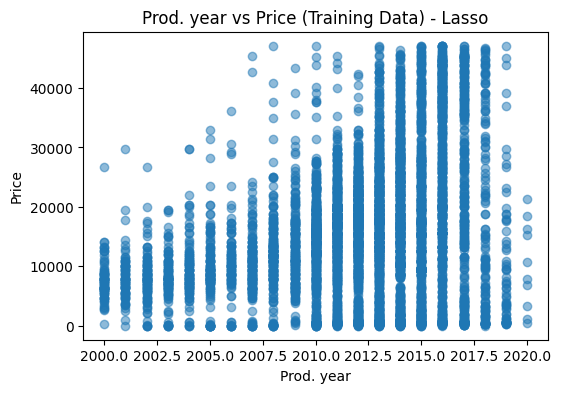

In [30]:
features = ['Mileage', 'Engine volume', 'Prod. year']

for feature in features:
    plt.figure(figsize=(6,4))
    plt.scatter(X_train[feature], y_train, alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel("Price")
    plt.title(f"{feature} vs Price (Training Data) - Lasso")
    plt.show()

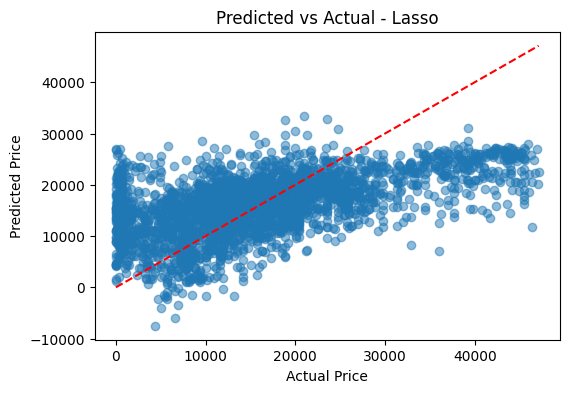

In [31]:
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred_test_lasso, alpha=0.5)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual - Lasso")
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color='red',
    linestyle='--'
)
plt.show()


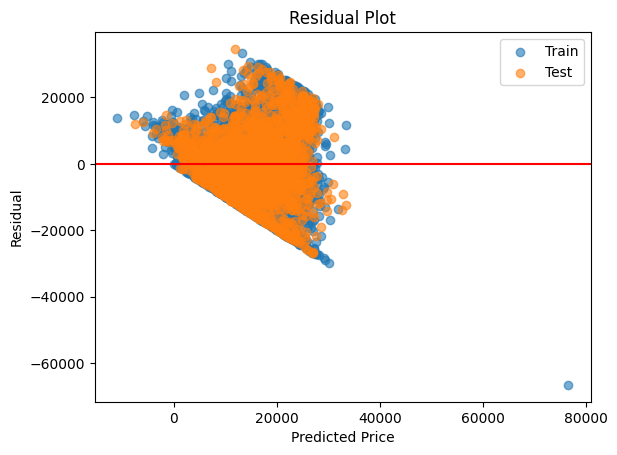

,Metric,Value
0,R2,2.943406e-01
1,MSE,8.658600e+07
2,MAE,7.330100e+03
3,RMSE,9.305160e+03


In [32]:
y_train_pred = grid_lasso.predict(X_train)

plt.scatter(y_train_pred, y_train - y_train_pred, label="Train", alpha=0.6)
plt.scatter(yl_pred, y_test - yl_pred, label="Test", alpha=0.6)
plt.axhline(0, color="red")
plt.legend()
plt.title("Residual Plot")
plt.xlabel("Predicted Price")
plt.ylabel("Residual")
plt.show()

error_matrix


## **Evaluasi Ridge**

In [33]:
y_pred_ridge = grid_ridge.best_estimator_.predict(X_test)

error_matrix_ridge = pd.DataFrame({
    'Metric': ['R2', 'MSE', 'MAE', 'RMSE'],
    'Value': [
        r2_score(y_test, y_pred_ridge),
        mean_squared_error(y_test, y_pred_ridge),
        mean_absolute_error(y_test, y_pred_ridge),
        np.sqrt(mean_squared_error(y_test, y_pred_ridge))
    ]
})

error_matrix_ridge


,Metric,Value
0,R2,2.941729e-01
1,MSE,8.660658e+07
2,MAE,7.322765e+03
3,RMSE,9.306266e+03


## **Feature Ridge**

In [34]:
best_selector_ridge = grid_ridge.best_estimator_.named_steps['feature_selection']
selected_features_ridge = X_train.columns[best_selector_ridge.get_support()]

print("Selected features (Ridge):")
print(selected_features_ridge)

Selected features (Ridge):
Index(['Levy', 'Manufacturer', 'Model', 'Prod. year', 'Category',
       'Leather interior', 'Fuel type', 'Engine volume', 'Mileage',
       'Gear box type', 'Drive wheels', 'Doors', 'Wheel', 'Color', 'Airbags'],
      dtype='object')


## **Data Visualization**

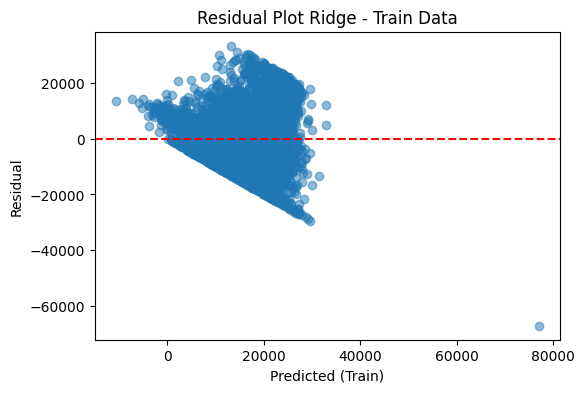

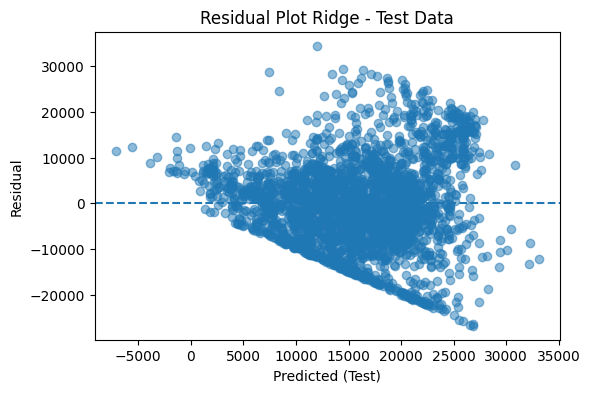

In [35]:
best_model_ridge = grid_ridge.best_estimator_

y_pred_train_ridge = best_model_ridge.predict(X_train)
y_pred_test_ridge  = best_model_ridge.predict(X_test)

plt.figure(figsize=(6,4))
plt.scatter(y_pred_train_ridge, y_train - y_pred_train_ridge, alpha=0.5)
plt.axhline(0, linestyle='--',color ="red")
plt.xlabel("Predicted (Train)")
plt.ylabel("Residual")
plt.title("Residual Plot Ridge - Train Data")
plt.show()


plt.figure(figsize=(6,4))
plt.scatter(y_pred_test_ridge, y_test - y_pred_test_ridge, alpha=0.5)
plt.axhline(0, linestyle='--')
plt.xlabel("Predicted (Test)")
plt.ylabel("Residual")
plt.title("Residual Plot Ridge - Test Data")
plt.show()

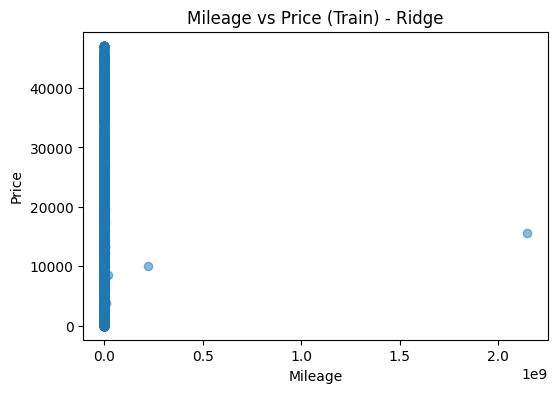

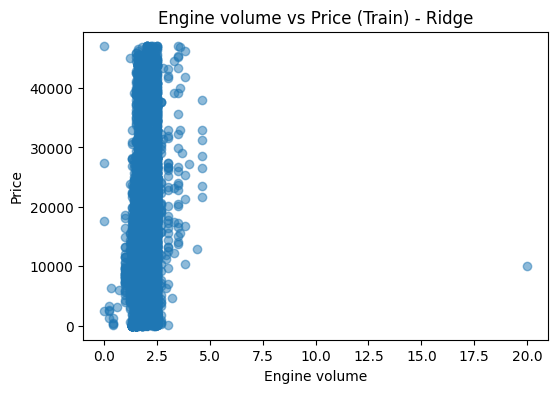

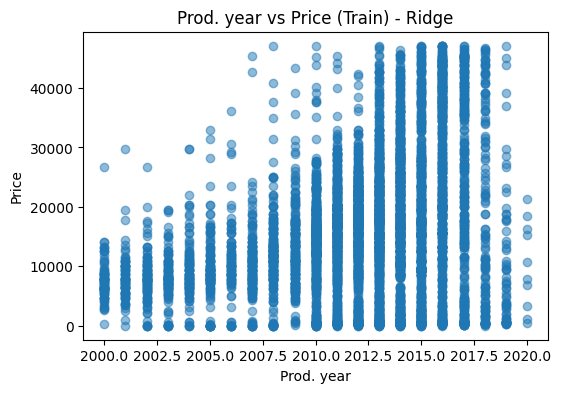

In [36]:
features = ['Mileage', 'Engine volume', 'Prod. year']

for feature in features:
    plt.figure(figsize=(6,4))
    plt.scatter(X_train[feature], y_train, alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel("Price")
    plt.title(f"{feature} vs Price (Train) - Ridge")
    plt.show()

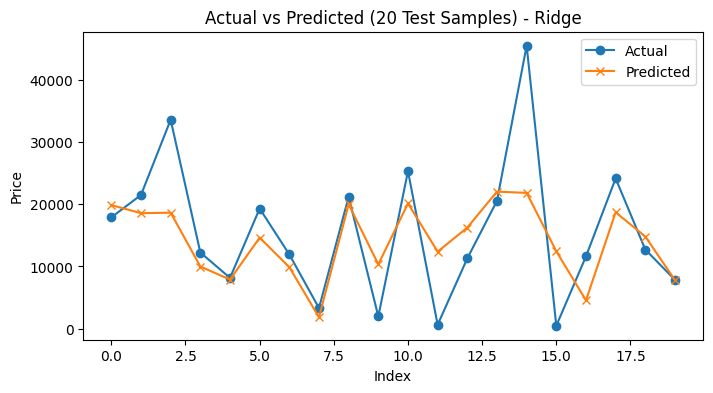

In [37]:
plt.figure(figsize=(8,4))
plt.plot(y_test.values[:20], label='Actual', marker='o')
plt.plot(y_pred_test_ridge[:20], label='Predicted', marker='x')
plt.legend()
plt.xlabel("Index")
plt.ylabel("Price")
plt.title("Actual vs Predicted (20 Test Samples) - Ridge")
plt.show()

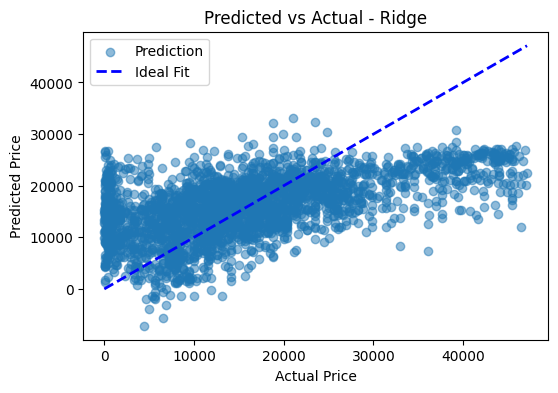

In [38]:
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred_test_ridge, alpha=0.5, label='Prediction')

plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color='blue',
    linestyle='--',
    linewidth=2,
    label='Ideal Fit'
)

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual - Ridge")
plt.legend()
plt.show()
